# 18. 강화 학습

강화 학습(Reinforcement Learning)은 요즘 머신러닝에서 가장 흥미진진한 분야이자 가장 오래된 분야이다. 강화 학습이 현대에 다시 재조명을 받은 시기는 2013년에 딥마인드에서 시도한 <a href="https://arxiv.org/pdf/1312.5602.pdf?source=post_page---------------------------">아타리게임들에 대해 수행된 연구</a>때문입니다. 이 연구에서 기계는 화면 픽셀에 대한 데이터만 입력으로 받고 <a href="https://www.datascienceassn.org/sites/default/files/Human-level%20Control%20Through%20Deep%20Reinforcement%20Learning.pdf">게임 규칙에 대한 어떤 사전 정보없이 대부분 사람을 능가하는 성과</a>를 냈다.

딥마인드가 이러한 성과를 낼수 있던 이유는? 강화 학습 분야에 강력한 딥러닝을 적용했기 때문이다.

18장에서는,
* 강화 학습의 정의 및 활용 분야
* 정책 그라디언트, 심층 Q-네트워크

## 18.1. 보상을 최적화하기 위한 학습

### 강화 학습의 구성요소

* 에이전트: 인공지능 플레이어
* 환경: 에이전트가 솔루션을 찾기 위한 무대
* 행동: 에이전트가 환경 안에서 시행하는 상호작용
* 보상: 에이전트의 행동에 따른 점수 혹은 결과

위의 4가지 요소를 가지고 강화학습은 **'에이전트는 관측을 하고 주어진 환경에서 행동을 하고, 이에 대한 결과로 보상을 받는다'**라는 문장으로 요약할 수 있다. 에이전트는 환경 아래에서 시행착오를 겪으며 보상을 최대로 하는 방향으로 학습한다. 강화학습은 자율주행 자동차, 추천 시스템, 웹페이지에 광고 배치, 이미지 분류 시스템의 제어 등에 사용될 수 있다.

## 18.2. 정책 탐색

에이전트가 행동을 결정하기 위해 사용하는 알고리즘을 정책(policy)라고 한다. 아래의 그림과 같이 Agent가 위치한 상태를 입력으로 받고 행동을 출력하는 신경망이 정책이 될 수 있다.

![RL_figure](../../img/RL_figure.jpg)

### 강화 학습의 예시; 청소기

* Agent: 30분 동안 수집한 먼지의 양을 보상으로 받는 로봇 진공청소기
* 정책: 매 초마다 p의 확률로 전진 or (1-p)의 확률로 왼쪽 또는 오른쪽으로 랜덤하게 회전; 회전의 각도는 -r과 +r 사이의 랜덤한 각도

**어떻게 훈련할 수 있을까?(정책탐색; Policy Search)**
1. 무작위 방식: 정책 파라미터들에 대해 무작위로 시행을 수행하고 성능이 좋은 조합을 선택
2. 유전 알고리즘(Genetic Algorithm): 1세대 정책 100개를 랜덤하여 생성하고, 하위 80개의 정책을 drop. 남은 20개를 활용하여 자식 정책 4개를 생성한다. 자식 정책 4개는 복사된 부모의 정책과 약간의 무작위 성을 설정한 것.
3. 정책 그라디언트(Policy Gradient): 정책 파라미터에 대한 보상의 그라디언트를 평가하여 높은 보상의 방향을 따르는 그라디언트로 파라미터를 수정하는 최적화 기법


## 18.3. OpenAI 짐

강화 학습 에이전트 훈련을 위한 최소한의 시뮬레이션 환경을 제공하는 패키지

간단하게 확인해 볼 환경은 CartPole이라는 아타리의 게임 중 기울어지는 막대를 세우는 게임이다. 

CartPole 환경에서 return되는 관측값은 아래와 같이 구성된다.

[수평 위치(0.0=중앙), 카트의 속도(양수=우측; 음수=좌측), 막대의 각도(0.0=수직), 막대의 각속도(양수=시계방향; 음수=반시계방향)]

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([-0.03209875, -0.01271688, -0.04609547,  0.03559415])

In [2]:
env.action_space

Discrete(2)

In [3]:
action = 1
obs, reward, done, info = env.step(action)

In [4]:
obs

array([-0.03235308,  0.18303474, -0.04538359, -0.27126866])

In [5]:
reward

1.0

In [6]:
done

False

In [7]:
info

{}

In [8]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [9]:
rewards_mean = np.mean(totals)
rewards_std = np.std(totals)
rewards_min = np.min(totals)
rewards_max = np.max(totals)

print("mean:{:.2f}; std:{:.4f}; min:{}; max:{}".format(rewards_mean,rewards_std,rewards_min,rewards_max))

mean:42.11; std:8.9641; min:24.0; max:72.0


## 18.4 신경망 정책

신경망 정책에서는 관측값을 통해 특정 결과에 대한 확률을 추정한다. 그리고 추정환 확률을 기반으로 랜덤으로 행동하도록 선택한다. 그렇다면 여기서 왜 '랜덤'하게 행동하도록 선택할까? 그 이유는 에이전트가 새로운 행동을 탐험하고 잘 할 수 있는 행동을 활용하는 행동을 유도하기 위함이다. 

일반적으로 각 관측은 환경에 대한 완전한 상태를 갖고 있기 때문에 과거 관측값에 대한 고려가 필요없다(e.g) CartPole). 그러나 관측에 잡음이 있는 경우에는 가능성있는 현재 상태의 추정을 위해 지난 관측 몇 개를 사용하는 것이 좋다.

## 18.5. 행동 평가: 신용 할당 문제

강화 학습에서는 일반적인 지도학습과는 달리 학습에 대한 평가 시, 실제 값 또는 Label이 주어지지 않는다. 다시 말해, 학습을 평가하는데 있어 사용되는 지표는 행동으로 주어지는 보상(reward)밖에 없다는 것이다. 그렇다면 에이전트가 수행한 각 행동에 대해 어떤 것이 좋고 나쁨을 구별할 수 있을까? 이는 신용 할당 문제(credit assignment problem)이라고 불린다.

위의 문제를 해결하기 위해 행동이 일어난 후 각 단계마다 할인 계수(discount factor; $\gamma$)를 적용한 보상을 모두 합하여 행동을 평가하는 것입니다. 이렇게 보상이 모두 합쳐진 값을 대가(return)이라고 부릅니다.

<div align="center" style="margin-top:20px">$0\le\gamma(할인 계수; discount factor)\ge1$</div>
<div align="center" style="margin-top:10px"><b>할인 계수 범위</b></div>

할인 계수는 0과 1사이의 값으로 구성되며, 값이 클 수록 미래 시점에 주어지는 보상에 대해 우선순위롤 높게주는 것이고, 값이 낮을 수록 현재 시점에 주어지는 보상에 우선순위를 높게 주는 것이다. 일반적으로 $0.9~0.99$사이의 값을 준다.

e.g) 0.95: 13step 이후의 보상 50% 할인; 0.99: 69step 이후의 보상 50% 할인

위의 원리로 수행하게 된다면, 좋은 행동 후에 나쁜 행동이 이어져 낮은 대가를 받을 수 있다. 하지만, 평균적으로 다른 가능한 행동과 비교하여 각 행동이 얼마나 좋은지 혹은 나쁜지를 추정해야 한다. 이를 행동이익이라고 부르며, 많은 에피소드를 실행하여 모든 행동의 대가를 정규화해야 한다.

## 18.6. 정책 그라디언트

### REINFORCEMENT 알고리즘

참고

https://towardsdatascience.com/learning-reinforcement-learning-reinforce-with-pytorch-5e8ad7fc7da0

https://github.com/g6ling/Reinforcement-Learning-Pytorch-Cartpole/tree/master/PG/1-REINFORCE

https://wonseokjung.github.io/page5/

1. 먼저 신경망 정책이 여러 번에 걸쳐 게임을 플레이하고 매 스텝마다 선택된 행동이 더 높은 가능성을 가지도록 만드는 그라디언트를 계산합니다. 하지만 그라디언트를 적용하지는 않는다.
2. 에피소드를 몇 번 실행한 다음, 각 행동의 이익을 계산한다.
3. 한 행동의 이익이 양수이면, 이 행동이 좋은 것임을 의미하므로 미래에 선택될 가능성이 높도록 앞서 계산한 그라디언트를 적용합니다. 그러나 행동이익이 음수이면 이 행동이 나쁜 것임을 의미하므로 미래에 이 행동이 덜 선택되도록 반대의 그라디언트를 적용합니다. 이는 각 그라디언트 벡터와 그에 상응하는 행동의 이익을 곱하면 됩니다.
4. 마지막으로 모든 결과 그라디언트 벡터를 평균 내어 경사 하강법 스텝을 수행합니다.

![sudo_REINFORCMENT](../../img/sudo_REINFORCEMENT.png)


### 주요 파라미터
* step size
* distcount rate
* batch size
* max epsiodes

### 정책 손실 $L(\theta)$
 신경망을 통해 도출되는 값은 확률분포를 따른다. 그렇기 때문에 $\pi(a | s,\theta)$는 신경망에서 각 상태에 대해 확률의 평균값을 얻기 위함이다. 그리고 확률의 평균 값을 할인 계수로 곱하여 신경망의 기대값을 계산한다.


In [10]:
env_name = 'CartPole-v1'
gamma = 0.99
lr = 0.001
goal_score = 200
log_interval = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

class Memory(object):
    def __init__(self):
        self.memory = deque()

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))

    def sample(self):
        memory = self.memory
        return Transition(*zip(*memory)) 

    def __len__(self):
        return len(self.memory)

In [12]:
# from config import gamma
class QNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(QNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc_1 = nn.Linear(num_inputs, 128)
        self.fc_2 = nn.Linear(128, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)

    def forward(self, input):
        x = F.relu(self.fc_1(input))
        policy = F.softmax(self.fc_2(x))
        return policy

    # 매 종료된 에피소드마다 각 행동을 평가하기 위한 함수
    @classmethod
    def train_model(cls, net, transitions, optimizer):
        states, actions, rewards, masks = transitions.state, transitions.action, transitions.reward, transitions.mask

        states = torch.stack(states)
        actions = torch.stack(actions)
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)

        returns = torch.zeros_like(rewards)
        
        running_return = 0
        
#         tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
#          1.,  1.,  1.,  1.,  1., -1.])
#         print(rewards)
        
        # 3: 각 state 별 미래가치를 현재가치로 할인한 보상의 값
        # 각 state에서 추정한 action으로 얻은 reward를 역순으로하여 미래가치로 할인을 수행
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + gamma * running_return * masks[t]
            returns[t] = running_return
            
#         print(returns)
#         tensor([ 1.6557e+01,  1.5714e+01,  1.4863e+01,  1.4003e+01,  1.3134e+01,
#          1.2257e+01,  1.1370e+01,  1.0475e+01,  9.5708e+00,  8.6574e+00,
#          7.7348e+00,  6.8028e+00,  5.8614e+00,  4.9105e+00,  3.9500e+00,
#          2.9798e+00,  1.9998e+00,  1.0099e+00,  1.0000e-02, -1.0000e+00])

        # 정책 그라디언트를 학습하기 위한 신경망의 input으로 매 agent의 step별 state를 투입
        policies = net(states)
        policies = policies.view(-1, net.num_outputs)
        
#      https://subinium.github.io/pytorch-Tensor-Variable/
#      detach reason: pytorch에서 텐서를 복제하기 위한 방법. 복사하면서 이전 텐서의 gradient에는 영향을 미치지 않기 위해서 사용함.
        log_policies = (torch.log(policies) * actions.detach()).sum(dim=1)
        
#     정책들 중에서도 선택된 action에 대한 정책만을 선정하여 loss 값에 사용
        loss = (-log_policies * returns).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss

    # 행동을 return하는 함수
    def get_action(self, input):
        policy = self.forward(input)
        # 왼쪽(0)과 오른쪽(1) 가속을 할 확률을 return 받음
        # 0: 왼쪽인 확률을 기준으로 랜덤으로 다음 action을 선정 => 이는 exploration 과 exploitng 사이의 균형을 맞추기 위함
        policy = policy[0].data.numpy()

        action = np.random.choice(self.num_outputs, 1, p=policy)[0]
        return action

### REINFORCE 알고리즘 K-batch update 미반영 code
출처. <a href="https://github.com/g6ling/Reinforcement-Learning-Pytorch-Cartpole/tree/master/PG/1-REINFORCE">github repo</a>

In [13]:
env = gym.make(env_name)
env.seed(500)
torch.manual_seed(500)

num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
print('state size:', num_inputs)
print('action size:', num_actions)

net = QNet(num_inputs, num_actions)

optimizer = optim.Adam(net.parameters(), lr=lr)

net.to(device)
net.train()
running_score = 0
# steps = 0
loss = 0

# 1: 
for e in range(3000):
    done = False
    memory = Memory()

    steps = 0
    score = 0
    state = env.reset()
    state = torch.Tensor(state).to(device)
    state = state.unsqueeze(0)

    # 2: 신경망에서 각 상태에 대해 확률의 평균값을 얻기
    while not done:
        steps += 1

        #현재 State를 가지고 다음에 취하게 될 action을 확률로 추정한 후 그 확률을 가지고 random하게 다음 action을 선정
        # next_state(obs)는 아래와 같이 구성
        # * 수평위치
        # * 카트의 속도
        # * 막대의 각도
        # * 막대의 각속도
        action = net.get_action(state)
        
        # 추정한 action을 가지고 수행 
        next_state, reward, done, _ = env.step(action)
        
        next_state = torch.Tensor(next_state)
        # 1차원 -> 2차원으로 확장 (행 개념 ) (4,) => (1,4)
        next_state = next_state.unsqueeze(0)

        mask = 0 if done else 1
        reward = reward if not done or score == 499 else -1

        # 0과 1중 action이 취해진 항목에 대해 1로 값을 반영
        action_one_hot = torch.zeros(2)
        action_one_hot[action] = 1
        # 메모리에  현재 state, 다음 state, 현재 state에서 취한 행동, 보상, mask를 기록
        memory.push(state, next_state, action_one_hot, reward, mask)

        # 학습 상황을 보기 위해  점수(== 보상) 출력
        score += reward
        state = next_state

    # 폴이 쓰러져서 한 eposiode가 끝난 경우, 그에 대한 학습을 수행
    loss = QNet.train_model(net, memory.sample(), optimizer)

    score = score if score == 500.0 else score + 1
    running_score = 0.99 * running_score + 0.01 * score
    if e % log_interval == 0:
        print('{} episode | steps: {} |score: {:.2f}'.format(
            e, steps ,running_score))
#         writer.add_scalar('log/score', float(running_score), e)
#         writer.add_scalar('log/loss', float(loss), e)

    if running_score > goal_score:
        break

state size: 4
action size: 2


C:\Users\kwon2\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]
C:\Users\kwon2\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 episode | steps: 36 |score: 0.35
10 episode | steps: 34 |score: 2.50
20 episode | steps: 28 |score: 4.66
30 episode | steps: 38 |score: 7.37
40 episode | steps: 17 |score: 8.43
50 episode | steps: 31 |score: 11.35
60 episode | steps: 35 |score: 13.06
70 episode | steps: 22 |score: 15.07
80 episode | steps: 38 |score: 19.19
90 episode | steps: 24 |score: 21.90
100 episode | steps: 44 |score: 24.03
110 episode | steps: 90 |score: 26.23
120 episode | steps: 16 |score: 27.06
130 episode | steps: 66 |score: 28.69
140 episode | steps: 33 |score: 30.50
150 episode | steps: 104 |score: 32.30
160 episode | steps: 19 |score: 32.75
170 episode | steps: 67 |score: 33.74
180 episode | steps: 90 |score: 36.17
190 episode | steps: 67 |score: 37.55
200 episode | steps: 50 |score: 37.98
210 episode | steps: 129 |score: 40.29
220 episode | steps: 33 |score: 41.71
230 episode | steps: 38 |score: 41.82
240 episode | steps: 67 |score: 42.66
250 episode | steps: 38 |score: 42.93
260 episode | steps: 54 |s

### REINFORCE 알고리즘 K-batch update 반영 code

In [14]:
env = gym.make(env_name)
env.seed(600)
torch.manual_seed(600)

num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
print('state size:', num_inputs)
print('action size:', num_actions)

net = QNet(num_inputs, num_actions)

optimizer = optim.Adam(net.parameters(), lr=lr)

running_score = 0 

n_iterations = 3000
n_episodes_per_update = 10
n_max_steps = 200

net.to(device)

def get_action(model, state):
    policy = model.forward(state)
    policy = policy[0].data.numpy()
    action = np.random.choice(model.num_outputs, 1, p=policy)[0]
    return action

def train_model(model, transitions, optimizer):
    
    n_max_steps = len(transitions)
    n_steps = []
    
    n_steps_losses = []
    
    n_steps_states = list(map(lambda x: list(x.state),transitions))
    n_steps_actions = list(map(lambda x: list(x.action),transitions))
    n_steps_rewards = list(map(lambda x: torch.Tensor(x.reward),transitions))
    n_steps_masks = list(map(lambda x: torch.Tensor(x.mask),transitions))
    
    n_steps_returns = list(map(lambda x:torch.zeros_like(torch.Tensor(x.reward)),transitions))
    
    model.train()
    
    for i in range(n_max_steps):
        
        running_return = 0
        
        states = torch.stack(n_steps_states[i]).squeeze(1)
        actions = torch.stack(n_steps_actions[i])
        rewards = n_steps_rewards[i]
        masks = n_steps_masks[i]
        returns = n_steps_returns[i]
        
        n_steps.append(len(rewards))
        
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + gamma * running_return * masks[t]
            returns[t] = running_return
            
        policies = net(states)
        policies = policies.view(-1, model.num_outputs)
        
        log_policies = (torch.log(policies) * actions.detach()).sum(dim=1)
        
        loss = (-log_policies * returns).sum()
        n_steps_losses.append(loss)
        
    mean_loss = sum(n_steps_losses) / n_max_steps
    mean_steps = sum(n_steps) / n_max_steps
    
    optimizer.zero_grad()
    mean_loss.backward()
    optimizer.step()
    
    return mean_loss, mean_steps
    
    
def play_multiple_epsode(env,n_episodes_per_update,n_max_steps,model,optimizer):
    all_transitions = []
    
    model = model.to(device)
    model.train()
    
    scores = []
    
    for epsiode in range(int(n_episodes_per_update)):
        
        done = False
        memory = Memory()
        steps = 0
        score = 0
        state = env.reset()
        state = torch.Tensor(state).to(device)
        state = state.unsqueeze(0)
        
        for step in range(n_max_steps):
            action = get_action(model, state)
            # obs, reward, done, grads[???] 
            next_state, reward, done, _= env.step(action)
            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)
            
            mask = 0 if done else 1
            reward = reward if not done else -1
            
            # 0과 1중 action이 취해진 항목에 대해 1로 값을 반영
            action_one_hot = torch.zeros(2)
            action_one_hot[action] = 1
            
            # 메모리에  현재 state, 다음 state, 현재 state에서 취한 행동, 보상, mask를 기록
            memory.push(state, next_state, action_one_hot, reward, mask)
    
            score += reward
            state = next_state
    
            if done:
                all_transitions.append(memory.sample())
                break
                
        scores.append(score)
                
    mean_loss, mean_steps = train_model(net, all_transitions, optimizer) 
    return mean_loss, mean_steps, scores 

# 1: 전체 에피소드 시행동안 반복 수행
for e in range(n_iterations//n_episodes_per_update):
    # 2: 신경망에서 각 상태에 대해 확률의 평균값을 얻기
    mean_loss, mean_steps, scores = play_multiple_epsode(env,n_episodes_per_update,n_max_steps,net,optimizer)
    mean_score = np.mean(scores)
    
    mean_score = mean_score if mean_score == 500.0 else mean_score + 1
    running_score = 0.99 * running_score + 0.01 * mean_score
#     if e % log_interval == 0:
    print('{} episode | steps: {:.2f} |score: {:.2f}'.format(
        e*n_episodes_per_update, mean_steps ,running_score))
#         writer.add_scalar('log/score', float(running_score), e)
#         writer.add_scalar('log/loss', float(loss), e)

    if running_score > goal_score:
        break

state size: 4
action size: 2


C:\Users\kwon2\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]
C:\Users\kwon2\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 episode | steps: 28.10 |score: 0.27
10 episode | steps: 29.40 |score: 0.55
20 episode | steps: 25.50 |score: 0.79
30 episode | steps: 20.70 |score: 0.98
40 episode | steps: 29.10 |score: 1.25
50 episode | steps: 32.20 |score: 1.55
60 episode | steps: 24.90 |score: 1.78
70 episode | steps: 27.80 |score: 2.03
80 episode | steps: 46.20 |score: 2.46
90 episode | steps: 21.40 |score: 2.64
100 episode | steps: 25.70 |score: 2.86
110 episode | steps: 30.50 |score: 3.12
120 episode | steps: 26.30 |score: 3.35
130 episode | steps: 29.10 |score: 3.59
140 episode | steps: 32.50 |score: 3.87
150 episode | steps: 33.30 |score: 4.16
160 episode | steps: 28.90 |score: 4.39
170 episode | steps: 34.70 |score: 4.69
180 episode | steps: 32.10 |score: 4.95
190 episode | steps: 20.70 |score: 5.10
200 episode | steps: 31.50 |score: 5.35
210 episode | steps: 38.30 |score: 5.67
220 episode | steps: 29.70 |score: 5.90
230 episode | steps: 21.40 |score: 6.05
240 episode | steps: 44.80 |score: 6.42
250 episode

## 18.7 마르코프 결정 과정

### 마르코프 연쇄 (Markov Chain)
정해진 개수의 상태(s; state)를 가지고 있으며, 각 스텝마다 한 상태에서 다른 상태로 랜덤하게 전이 된다. 상태 $s$에서 상태 $s^\prime$으로 전이하기 위한 확률은 고정되어 있으며, 시스템에 메모리가 없으므로 **과거 상태에는 상관없이 $(s,s^\prime)$쌍에 만 의존하여 연쇄작용이 발생한다(== 마르코프 성질[markov property]을 가진다고도 한다).**

이를 도식화한 그림은 아래와 같으며, 특정 state에서 자기 자신으로 전이하는 확률이 1.0인 경우에는 종료 상태(absorbing state)라고 한다.

![markov_chain](../../img/markov_chain.png)
<div style="margin-top:10px;font-size:16px;font-weight:bold" align="center">마르코프 연쇄 도식</div>

### <a href="https://apps.dtic.mil/sti/pdfs/AD0606367.pdf">마르코프 결정 과정 (Markov Decision Process; MDP)</a>

MDP는 마르코프 연쇄와 비슷하지만 약간 다른점이 있다.
* 각 스텝에서 에이전트는 여러 가능한 행동 중 하나를 선택한다.
* 전이 확률은 선택된 행동에 따라 달라진다.
* 어떤 상태 전이는 보상(양수 또는 음수)를 반환한다.
* 에이전트의 목적은 시간이 지남에 따라 보상을 극대화 하기 위한 정책을 찾는 것

![markov_decision_process](../../img/markov_decision_process.jpg)
<div style="margin-top:30px;font-size:16px;font-weight:bold" align="center">마르코프 결정 과정 도식</div>

어떤 상태의 최적의 상태가치(state value) $V*(s)$를 추정하는 방법을 MDP를 제안한 Richard Bellman은 찾아냈다. 이는 에이전트가 상태 s에 도달한 후 최적으로 행동한다고 가정하고 평균적으로 기대할 수 있는 할인된 미래 보상의 합을 말한다.

<div style="margin:15px" align="center">
$V^*(s) = \underset{a}{\max}\sum T(s,a,s^\prime)[R(s,a,s^\prime) + \gamma*V^*(s^\prime)]$
</div>
<div style="margin-top:10px;font-size:16px;font-weight:bold" align="center">벨먼 최적 방정식 </div>

* $T(s,a,s^\prime)$는 에이전트가 행동 a를 선택했을 때 상태 s에서 상태 $s^\prime$으로 전이될 확률
* $R(s,a,s^\prime)$는 에이전트가 행동 a를 선택해서 상태 s에서 상태 $s^\prime$로 이동되었을 떄 에이전트가 받을 수 있는 보상
* $\gamma$는 할인 계수

이를 통해 최적의 값을 얻어내기 위해서 가능한 경로들에 대해 0으로 초기화 한후, 가치 반복 알고리즘을 통해 업데이트를 수행한다.

<div style="margin:15px" align="center">
$V_{k+1}(s) = \underset{a}{\max}\underset{s^\prime}{\sum} T(s,a,s^\prime)[R(s,a,s^\prime) + \gamma*V_k(s^\prime)]$
</div>
<div style="margin-top:10px;font-size:16px;font-weight:bold" align="center">가치 반복 알고리즘 </div>

* $V_k(s)$는 알고리즘의 k번째 반복에서 상태 s의 추정가치를 나타냄

최적의 상태 가치를 아는 것은 정책을 평가 할 때 유용하지만, 에이전트를 위한 최적의 정책을 알려주지 않는다. 따라서 벨먼은 이를 보완한 Q-value라고 부르는 최적의 상태-행동가치를 추정할 수 있는 매우 비슷한 알고리즘을 발견했다.

상태-행동(s,a) 쌍에 대한 최적의 Q-가치인 $Q*(s,a)$는 에이전트가 상태 s에 도달해서 행동 a를 선택한 후 이 행동의 결과를 얻기 전에 평균적으로 기대할 수 있는 할인된 미래 보상의 합이다.

<div style="margin:15px" align="center">
$Q_{k+1}(s,a) = \underset{s^\prime}{\sum} T(s,a,s^\prime)[R(s,a,s^\prime) + \gamma*\underset{a^\prime}{\max}Q_k(s^\prime,a^\prime)]$
</div>
<div style="margin-top:10px;font-size:16px;font-weight:bold" align="center">Q-가치 반복 알고리즘 </div>

최적의 Q-가치를 구하게 되면, 최적의 정책인 $\pi*(s)$를 정의하는 것은 아래와 같다.

$\pi^*(s)=\underset{a}{argmax}Q^*(s,a)$

마지막으로 얻은 Q-가치에 대해 state(row)들에 대한 max값을 return 하는 것이다.

In [8]:
transition_probabilities = [
    # state 0에서 action 0, 1, 2이 state 0, 1, 2로 전이될 확률
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    # state 1에서 action 0, 1, 2이 state 0, 1, 2로 전이될 확률
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [
    [[10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [40, 0, 0], [0, 0, 0]]
]
# state 0, 1, 2에서 취할 수 있는 action
possible_actions = [[0,1,2], [0, 2], [1]]

In [9]:
Q_values = np.full((3,3),-np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [17]:
gamma = 0.95

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            # s state에서 a action을 취하여 sp state로 전이되는 확률 * s state에서  a action을 취하여 sp state로 전이될 때의 부상 + 할인 계수 * 순회를 통해 얻는 sp state의 최대 Q value
            Q_values[s,a] = np.sum([transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) for sp in range(3)])

In [18]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

## 18.8. 시간차 학습

독립적인 행동으로 이루어진 강화 학습 문제는 보통 마르코프 결정 과정으로 모델링 될 수 있다. 하지만 대부분의 에이전트는 앞선 예제와 달리 전이 확률이나 보상의 정도를 초기에는 알 수 없다. 이를 알기 위해 적어도 한 번은 각 상태와 전이를 경험해야 하고, 전이 확률에 대한 신뢰할 만한 추정을 위해서는 여러번 경험이 필요하다.

시간차 학습(Temporal Difference Learning; TD Learning)은 에이전트가 MDP에 대해 일부 정보만 알고 있을 때를 다룰 수 있도록 변형한 것이다. 일반적으로 에이전트가 초기에 가능한 상태와 행동만을 알고 다른 것은 모른다고 가정한다. 그래서 에이전트는 탐험 정책(Exploration Policy)을 사용하여 MDP를 탐험한다. 탐험이 진행될 수록 TD 학습 알고리즘이 실제로 관측된 전이와 보상에 근거하여 상태 가치의 추정값을 업데이트 한다.

$V_{k+1}(s) \leftarrow (1-\alpha)V_k(s) + \alpha(r+\gamma * V_k(s^\prime)) $ [식 1]

$V_{k+1}(s) \leftarrow V_k(s) + \alpha*\delta_k(s,r,s^\prime)$ 여기에서, $\delta_k(s,r,s^\prime) = r+\gamma*V_k(s^\prime)-V_k(s)$

* $\alpha$는 학습률
* $r+\gamma * V_k(s^\prime)$는 TD 타깃
* $\delta_k(s,r,s^\prime)$는 TD 오차

[식 1]의 표기를 $a\underset{\alpha}{\leftarrow} b$ 사용하여 아래와 같이 간략한 표기로 [식 2]로 표현할 수 있다.

$a\underset{\alpha}{\leftarrow} b = a_{k+1} \leftarrow (1-\alpha) * a_k+\alpha*b_k$

$V(s) \underset{\alpha}{\leftarrow} r+\gamma * V(s^\prime)$ [식 2]

## 18.9. Q-러닝

시간차 학습과 동일하게 Q-러닝(Q-Learning)알고리즘 은 전이 확률과 보상을 초기에 알지 못한 상황에서 Q-가치 반복 알고리즘을 적용한 것이다. Q-러닝은 에이전트가 플레이하는 것을 보고 점진적으로 Q-가치 추정을 향상하는 방식으로 작동한다. 따라서 정확한 Q-가치 추정을 얻게 되면 최적의 정책은 가장 높은 Q-가치를 가지는 행동을 선택하는 것이다.

$Q(s,a) \underset{\alpha}{\leftarrow} r+\gamma * \underset{a^\prime}{max}Q(s^\prime,a^\prime)$

$Q_{k+1}(s,a) {\leftarrow} (1-\alpha) * Q_{k}(s,a) + \alpha * (r+\gamma * \underset{a^\prime}{max}Q(s^\prime,a^\prime))$

각 상태와 행동마다 앞서 Q-가치와 동일하게 이로 얻은 보상과 기대할 수 있는 할인된 미래 보상의 합을 더한 이동 평균을 Q에 저장한다. 미래 보상의 합을 추정하는데 있어 타깃 정책이 이후로 최적으로 행동한다고 가정하고 상태 $s^\prime$에 대한 Q-가치 추정의 최댓값을 선택한다.

### off-policy & on-policy
* off-policy(e.g) Q-Learning): 훈련된 정책을 반드시 실행에 사용하지 않는 알고리즘
* on-policy(e.g) policy gradient): 훈련된 정책을 사용하여 환경을 탐험하는 알고리즘

In [21]:
def step(state,action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [22]:
Q_values = np.full((3,3),-np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [28]:
alpha0 = 0.05
decay = 0.005
gamma = 0.9
state = 0

for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state,action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1+ iteration * decay)
    Q_values[state,action] *= (1-alpha)
    Q_values[state,action] += alpha * (reward + gamma * next_value)
    state = next_state

In [34]:
Q_values

array([[18.36900895, 15.95016661, 12.97749804],
       [ 0.        ,        -inf, -7.9681517 ],
       [       -inf, 49.37705813,        -inf]])

In [35]:
Q_values.argmax(axis=1)

array([0, 0, 1], dtype=int64)

### 18.9.1. 탐험 정책

Q-Learning은 탐험 정책이 MDP를 충분히 탐험해야 작동한다. 랜덤한 정책은 결국 모든 상태와 전이를 여러번 경험할 수 있지만, 극단적으로 오래 걸릴 수 있다. 그래서 더 나은 방법으로 $\epsilon$ 그리디 정책($\epsilon$-greedy policy)를 활용하는 것이다.

각 스텝에서 $\epsilon$의 확률로 랜덤하게 행동하거나, 1-$\epsilon$의 확률로 그 순간 가장 최선인 것으로 행동한다.

이 방식의 장점은 Q-가치 추정이 점점 향상되기 때문에 환경에서 관심 있는 부분을 살피는 데 점점 많은 시간을 사용한다는 점이다. 그러나 이 방법 또한 알려지지 않은 지점을 방문하는데 있어서 시간이 소요되며, $\epsilon$의 값은 높게 시작해서 점점 감소되는 것이 일반적이다.

다른 방식으로는 탐험의 가능성에 의존하는 대신 이전에 많이 시도하지 않았던 행동을 시도하도록 탐험 정책을 강조하는 방법이 있다. 이는 Q-가치 추정에 보너스를 추가하는 방식으로 구현한다.

<div style="margin-top:15px" align="center">$Q(s,a) \underset{\alpha}{\leftarrow} r+\gamma*\underset{\alpha^\prime}{max} \ f(Q(s^\prime,a^\prime),N(s^\prime,a^\prime))$</div>
<div align="center"><b>탐험 함수를 사용한 Q-러닝</b></div>

* $N(s^\prime,a^\prime)$는 상태 $s^\prime$에서 행동 $a^\prime$를 선택한 횟수를 카운트 합니다.
* $f(Q,N)$은 $f(Q,N)=Q+k/(1+N)$와 같은 탐험 함수(exploration function)이다. 여기서 k는 에이전트가 알려지지 않은 곳에서 얼마나 흥미를 느끼는지 나타내는 하이퍼 파라미터이다.

### 18.9.2. 근사 Q-러닝과 심층 Q-러닝

Q-러닝의 주요문제는 많은 상태와 행동을 가진 대규모의 MDP에 적용하기 어렵다는 것.

이에 대한 해결책은 어떤 상태-행동(s,a) 쌍의 Q-가치를 근사하는 $Q_{\theta}(s,a)$를 적절한 개수의 파라미터를 사용하여 찾는것이며, 이를 근사 Q-러닝이라고 한다. 오랫동안 상태에서 직접 뽑아낸 특성들을 선형조합(e.g) 가까운 특정 값과의 거리 및 방향) 하는 방식으로 권장되었다. 그러나 2013년 딥마인드에서는 심층 신경망을 활용했으며, 이를 심층 Q-네트워크(DQN)이라고 하며, 근사 Q-러닝을 위해 DQN을 사용하는 것을 심층 Q-러닝이라 한다.

#### DQN을 어떻게 훈련시켜야 하는가?

밸먼 식으로 인해 근사 Q-가치는 상태 s에서 행동 a를 실행했을 때 관측된 보상 r과 그 이후에 최적으로 행동해서 얻은 할인된 가치를 더한 값에 가능한 가깝게 되어야 한다. 미래의 할인된 가치를 추정하기 위해서는 다음 상태 $s^\prime$과 모든 가능한 행동 $a^\prime$에 대해 DQN을 실행한다. 이로 인해 모든 가능한 행동에 대한 미래의 근사 Q-가치를 어을 수 있다. 그다음에 가장 높은 것을 고르고 할인을 적용하여 할인된 미래 보상의 추정을 얻을 수 있다.

<div style="margin-top:15px" align="center">$Q_{target}(s,a)=r+\gamma * \underset{a^{\prime}}{max}Q_{\theta}(s^\prime,a^{\prime})$</div>
<div align="center"><b>타깃 Q-가치</b></div>

위의 타깃 Q-가치로 추정된 Q-가치 $Q(s,a)$ 사이의 제곱 오차를 최소화 한다.

## 18.10. 심층 Q-러닝 구현하기

이론적으로는 상태-행동 쌍을 입력받고 근사 Q-가치를 출력하는 신경망이 필요하다. 그러나 실제로는 상태를 받고 가능한 행동에 대한 근사 Q-가치를 출력하는 것이 훨씬 효율적이다.

### My code

In [10]:
class DQN(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(DQN,self).__init__()
        self.model = nn.Sequential(
                                nn.Linear(input_shape,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,output_shape),
                                nn.Softmax(),
                            )
        
    def forward(self, x):
        return self.model(x)

In [11]:
env = gym.make("CartPole-v0")
input_shape = env.observation_space.shape[0]
output_shape= env.action_space.n

dqn = DQN(input_shape,output_shape)

In [12]:
def epsilon_greedy_policy(state,eplison=0):
    if np.random.rand() < eplison:
        return np.random.randint(2)
    else:
        state = torch.Tensor(state)
        Q_values = dqn(state[np.newaxis])
        return torch.argmax(Q_values[0]).item()

In [13]:
from collections import deque

# experience= (state, action, reward, next_state, done)
replay_buffer = deque(maxlen=2000)

In [14]:
# experience= (state, action, reward, next_state, done)
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer),size = batch_size)
    # random으로 experience를 선정한 list
    batch = [ replay_buffer[index] for index in indices ]
    experiences = np.array([experience[i] for experience in batch for i in range(5)]).reshape(-1,5)
    states, actions, rewards, next_states, dones = experiences[:,0], experiences[:,1], experiences[:,2], experiences[:,3], experiences[:,4]
    return states, actions, rewards, next_states, dones

In [15]:
def play_one_step(env, state, epsilon):
    # eplison greedy에 의해 선택한 action
    action = epsilon_greedy_policy(state,epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state,action,reward,next_state,done))
    return next_state, reward, done, info

In [16]:
batch_size = 32
discount_factor = 0.95
optimizer = optim.Adam(dqn.parameters(),lr=0.001)
criterion = nn.MSELoss()

In [17]:
def training_step(batch_size):
    # 경험을 배치 사이즈만큼 샘플링
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    states = torch.stack(list(map(lambda x:torch.Tensor(x),states.tolist())))
    actions = list(map(lambda x:torch.Tensor(x),actions.tolist()))
    rewards = torch.Tensor(rewards.astype("int"))
    next_states = torch.stack(list(map(lambda x:torch.Tensor(x),next_states.tolist())))
    dones = torch.Tensor(dones.astype("bool"))
    
    # 경험의 다음 상태에서 가능한 모든 행동들에 대한 Q-가치를 예측
    # 항상 상호작용에 있어서 더 좋은 것만을 추구하기 때문에 max value로 지정
    next_Q_values = dqn(next_states)
    max_next_Q_values = torch.max(next_Q_values, axis=1).values.data
    target_Q_values = (rewards + (1-done) * discount_factor * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    
    # DQN이 경험한 각 상태-행동 쌍의 Q가치 계산
    action_one_hot = torch.zeros(2)
    action_one_hot[action] = 1
    
    all_Q_values = dqn(states)
    Q_values = torch.sum(all_Q_values * action_one_hot, axis=1).unsqueeze(1)
    
    loss = criterion(target_Q_values,Q_values)
    
    dqn.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [18]:
rewards = []
dqn.train()
for episode in range(600):
    obs = env.reset()
    epi_reward = 0
    for step in range(200):
        epsilon = max(1 - episode/500,0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        reward = reward if not done else -1
        epi_reward += reward
        if done:
            break
    rewards.append(epi_reward)
    if episode > 50:
        training_step(batch_size)

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


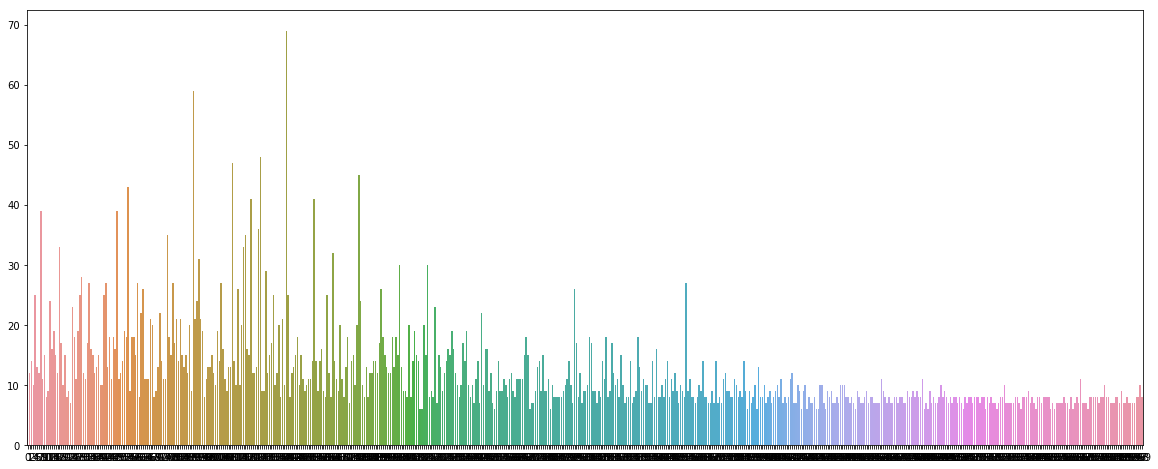

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[20,8])
sns.barplot(x=list(range(len(rewards))),y=rewards)
plt.show()

## 18.11. 심층 Q-러닝의 변종

### 18.11.1. 고정 Q-가치 타깃

Q-러닝 절차를 각 스텝에서 학습하고 에이전트를 움직이는데 사용되는 온라인 모델과 타겟을 정의하는데만 사용되는 타겟 모델로 이원화하여 구성한다. 타겟모델은 온라인 모델의 복사본과 동일하며, 임의의 episode마다 이를 업데이트 한다.

타겟 모델이 온라인 모델보다 자주 업데이트 되지 않으므로, Q-가치 타깃이 더 안정적이며 앞서 언급한 피드백 반복을 완화하고 이에 대한 영향이 감소한다.

In [22]:
from copy import deepcopy

env = gym.make("CartPole-v0")
input_shape = env.observation_space.shape[0]
output_shape= env.action_space.n

online_dqn = DQN(input_shape,output_shape)
target_dqn = online_dqn

In [23]:
def training_step(batch_size):
    # 경험을 배치 사이즈만큼 샘플링
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    states = torch.stack(list(map(lambda x:torch.Tensor(x),states.tolist())))
    actions = list(map(lambda x:torch.Tensor(x),actions.tolist()))
    rewards = torch.Tensor(rewards.astype("int"))
    next_states = torch.stack(list(map(lambda x:torch.Tensor(x),next_states.tolist())))
    dones = torch.Tensor(dones.astype("bool"))
    
    # 경험의 다음 상태에서 가능한 모든 행동들에 대한 Q-가치를 예측
    next_Q_values = target_dqn(next_states)
    max_next_Q_values = torch.max(next_Q_values, axis=1).values.data
    target_Q_values = (rewards + (1-done) * discount_factor * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    
    # DQN이 경험한 각 상태-행동 쌍의 Q가치 계산
    action_one_hot = torch.zeros(2)
    action_one_hot[action] = 1
    
    all_Q_values = online_dqn(states)
    Q_values = torch.sum(all_Q_values * action_one_hot, axis=1).unsqueeze(1)
    
    loss = criterion(target_Q_values,Q_values)
    
    online_dqn.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [24]:
rewards = []
online_dqn.train()
for episode in range(600):
    
    obs = env.reset()
    epi_reward = 0
    for step in range(200):
        epsilon = max(1 - episode/500,0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        reward = reward if not done else -1
        epi_reward += reward
        if done:
            break
    rewards.append(epi_reward)
    if episode > 50:
        training_step(batch_size)
    if episode % 50 == 0:
        target_dqn.load_state_dict(online_dqn.state_dict())

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimensio

C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kwon2\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


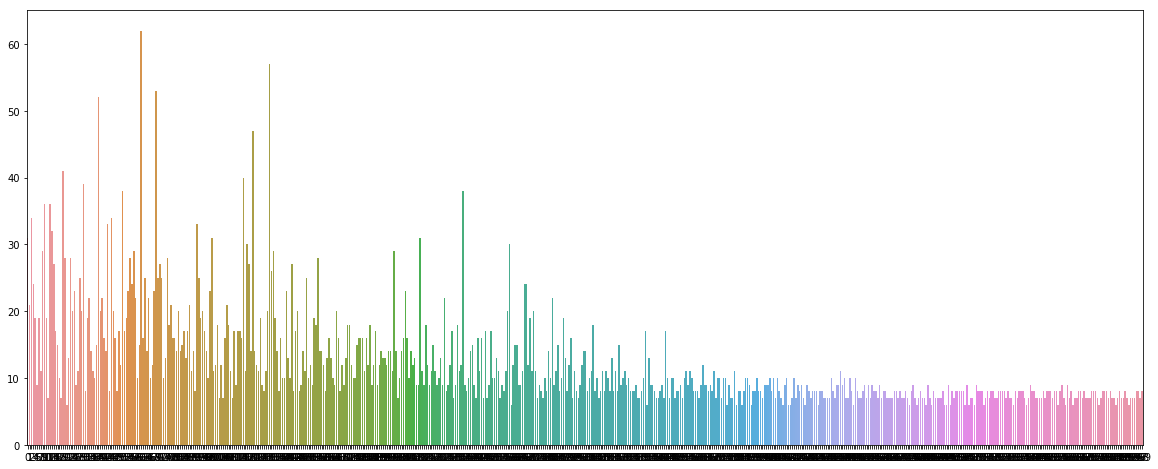

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[20,8])
sns.barplot(x=list(range(len(rewards))),y=rewards)
plt.show()

### 18.11.2. Double DQN
https://arxiv.org/pdf/1509.06461.pdf

모든 행동이 동일하게 좋다고 가정하자. 그렇다면 타깃 모델이 추정한 Q-가치가 동일해야 하지만, 근사값이므로 우연히 다른 것보다 조금 높은 값이 있다. 타깃 모델은 항상 더 큰 Q-가치를 선택하므로 평균 Q-가치보다 더 커지고 실제 Q-가치가 과대평가할 가능성이 높다.

이를 개선하기 위해 다음 상태에서의 최선의 행동을 선택할 때 타깃 모델 대신 온라인 모델을 사용하도록 제안한다. 그리고 타깃 모델은 최선의 행동에 대한 Q-가치를 추정할 때만 사용한다.

### 18.11.3. 우선 순위 기반 경험 재생
https://arxiv.org/pdf/1511.05952.pdf

재생 버퍼에서 경험을 균일하게 샘플링하는 것이 아니라 중요한 경험을 더 자주 샘플링하는 방법.
이를 중요도 샘플링(Importance Sampling; IS) 또는 우선 순위 기반 경험 재생(Priorized Experience Replay; PER)이라고 한다.

중요한 경험의 척도는 TD 오차가 크게 변화하는지로 볼 수 있다. 따라서 이떄 재생버퍼에 저장 시, 높은 우선순위 값을 부여하여 저장한다.

그러나, 샘플이 중요한 경험에 편향되어 있으므로 후녈ㄴ하는 동안 중요도에 따르 경험의 가중치를 낮춰 이 편항을 보상해주어야 한다. 다시말해 중요한 경험이 더 자주 샘플링되기를 원하지만 훈련과정에서 이 샘플에 낮은 가중치를 주어야 한다는 것이다.

### 18.11.4. 듀얼링 DQN; DDQN
https://arxiv.org/pdf/1511.06581.pdf

$Q(s,a)=V(s)+A(s,a)$

V(s): 상태s의 가치

이 상태에서 최선의 행동의 Q-가치와 같다. $V(s)=Q(s,a^*) = A(s,a^*)$

A(s,a): 상태 s에서 다른 모든 가능한 행동과 비교하여 행동 a를 선택했을 때의 이득